# Project 03
* Kaggle에서 진행했던 대회의 데이터(House Price Prediction)를 가지고 성능을 올려보자.
* [2019 ML month 2nd baseline 커널](https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline)을 베이스라인으로 작성했다.
* 

### 사용 라이브러리
* `xgboost` : 익스트림 그레이디언트 부스팅(Extreme Gradient Boosting)(version_1.7.5)
* `lightgbm` : Light Gradient-Boosting Machine(version_3.3.5)
* `missingno ` : 결측치 확인을 위한 라이브러리(version_0.5.2)

In [2]:
import warnings
warnings.filterwarnings("ignore") # 경고 무시

import os
from os.path import join 

import pandas as pd
import numpy as np

import missingno as msno # 결측치 확인

from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.model_selection import KFold, cross_val_score # 검증
from sklearn.metrics import mean_squared_error #검증
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb # 회귀 모델
import lightgbm as lgb  # 회귀 모델

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'pandas'

데이터 경로 설정

In [20]:
## Kaggle의 커널 내의 경로
# train_data_path = join('../input/2019-2nd-ml-month-with-kakr', 'train.csv')
# sub_data_path = join('../input/2019-2nd-ml-month-with-kakr', 'test.csv')

dir = os.getcwd()+'/House_Price_Prediction/'

train_data_path = join(dir, 'train.csv')
sub_data_path = join(dir, 'test_real.csv')

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

* `sub_data`는 제출용 데이터로 정답데이터인 집값 컬럼이 없다.
* 따라서, `sub_data`의 집값을 잘 예측해보자!

In [21]:
train_data = pd.read_csv(train_data_path)
sub_data = pd.read_csv(sub_data_path)

print('train data dim : {}'.format(train_data.shape))
print('sub data dim : {}'.format(sub_data.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


* `train_data`의 집값 컬럼을 `label`로 저장하고 컬럼을 지운다.
* 제출용 데이터와 합쳐서 전처리를 진행해보자~

In [22]:
label = train_data['price']
del train_data['price']

In [23]:
train_len = len(train_data)
data = pd.concat((train_data, sub_data), axis=0)
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 데이터 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다. 결측치가 있다면 해당부분이 하얗게 나온다.

<Axes: >

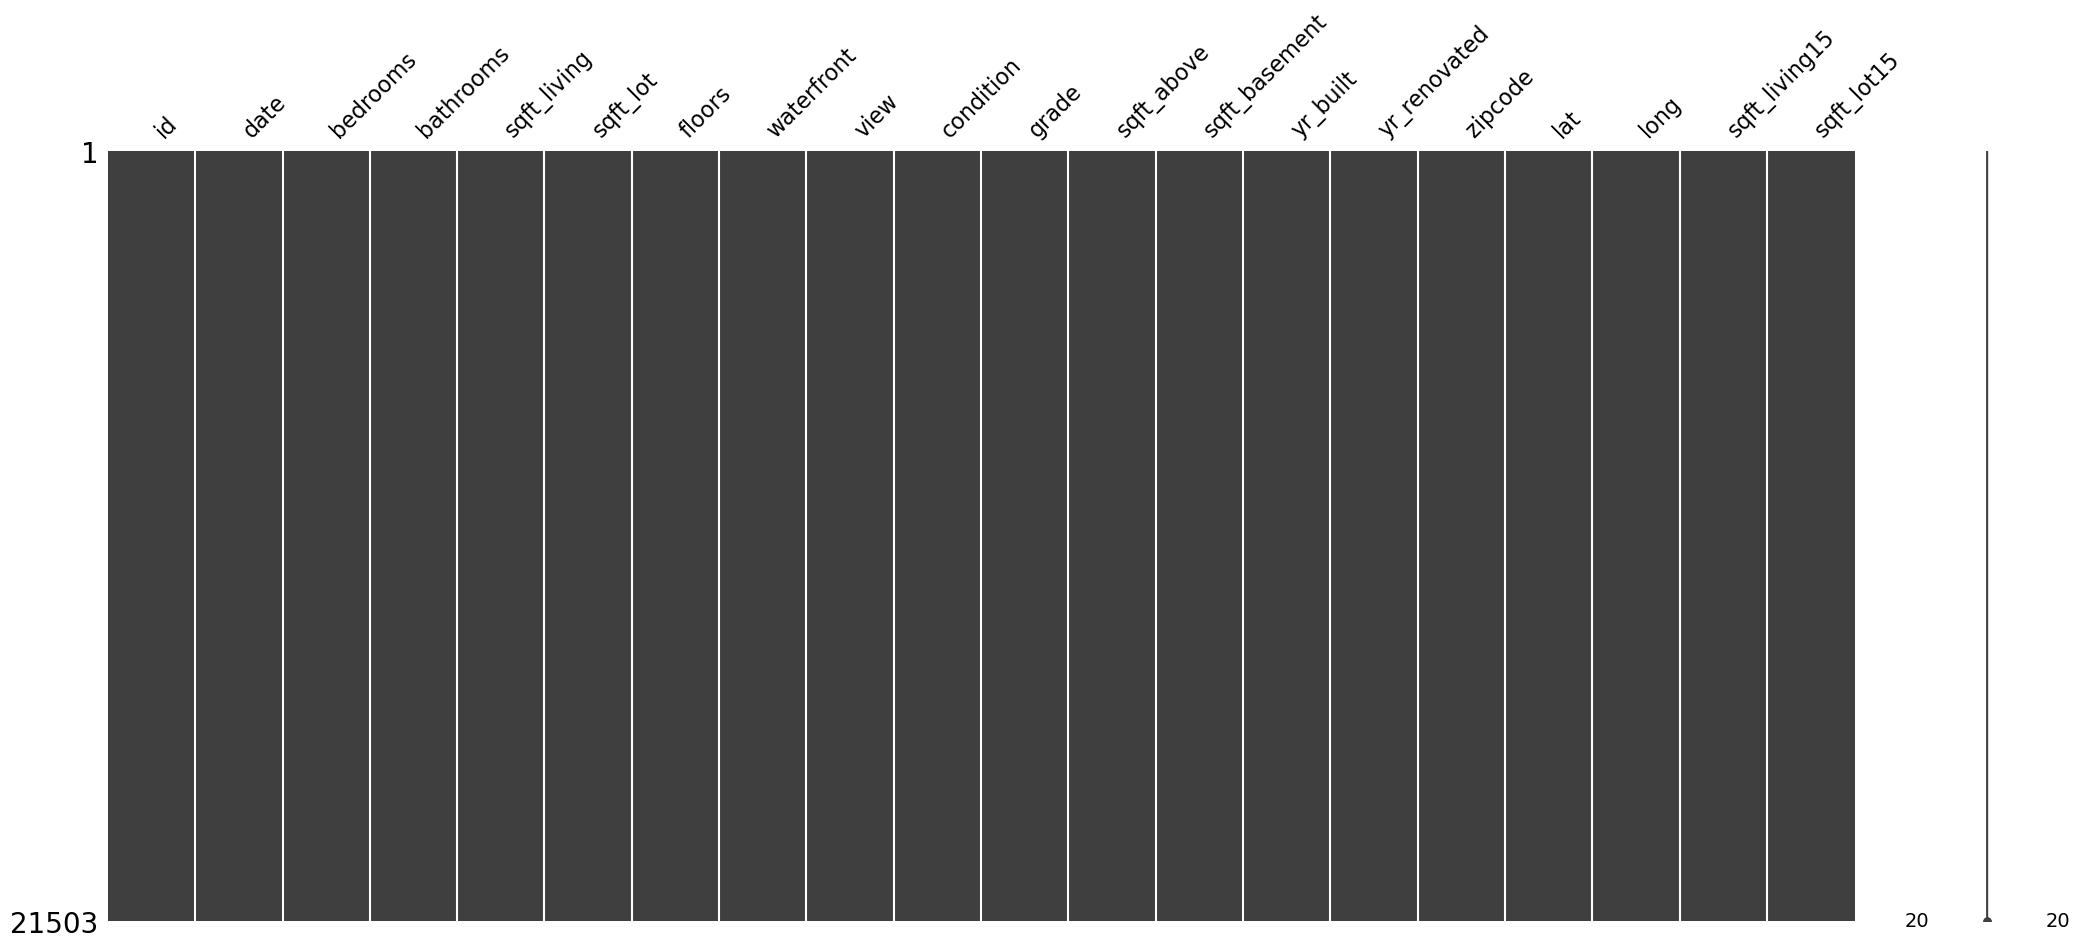

In [24]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [25]:
for c in data.columns:
    nul_data_bool = pd.isnull(data[c])
    print('{} : {}'.format(c, len(data.loc[nul_data_bool, c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.(	20141013T000000 -> 201410 )

In [26]:
sub_id = data['id'][train_len:]
del data['id']

In [27]:
data['date_ym'] = data['date'].apply(lambda x : str(x[:6])).astype(int)
del data['date']
data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_ym
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,201410
1,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,201502
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,201502
3,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,201406
4,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,201501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303,201406
6464,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230,201501
6465,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265,201502
6466,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,201406


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

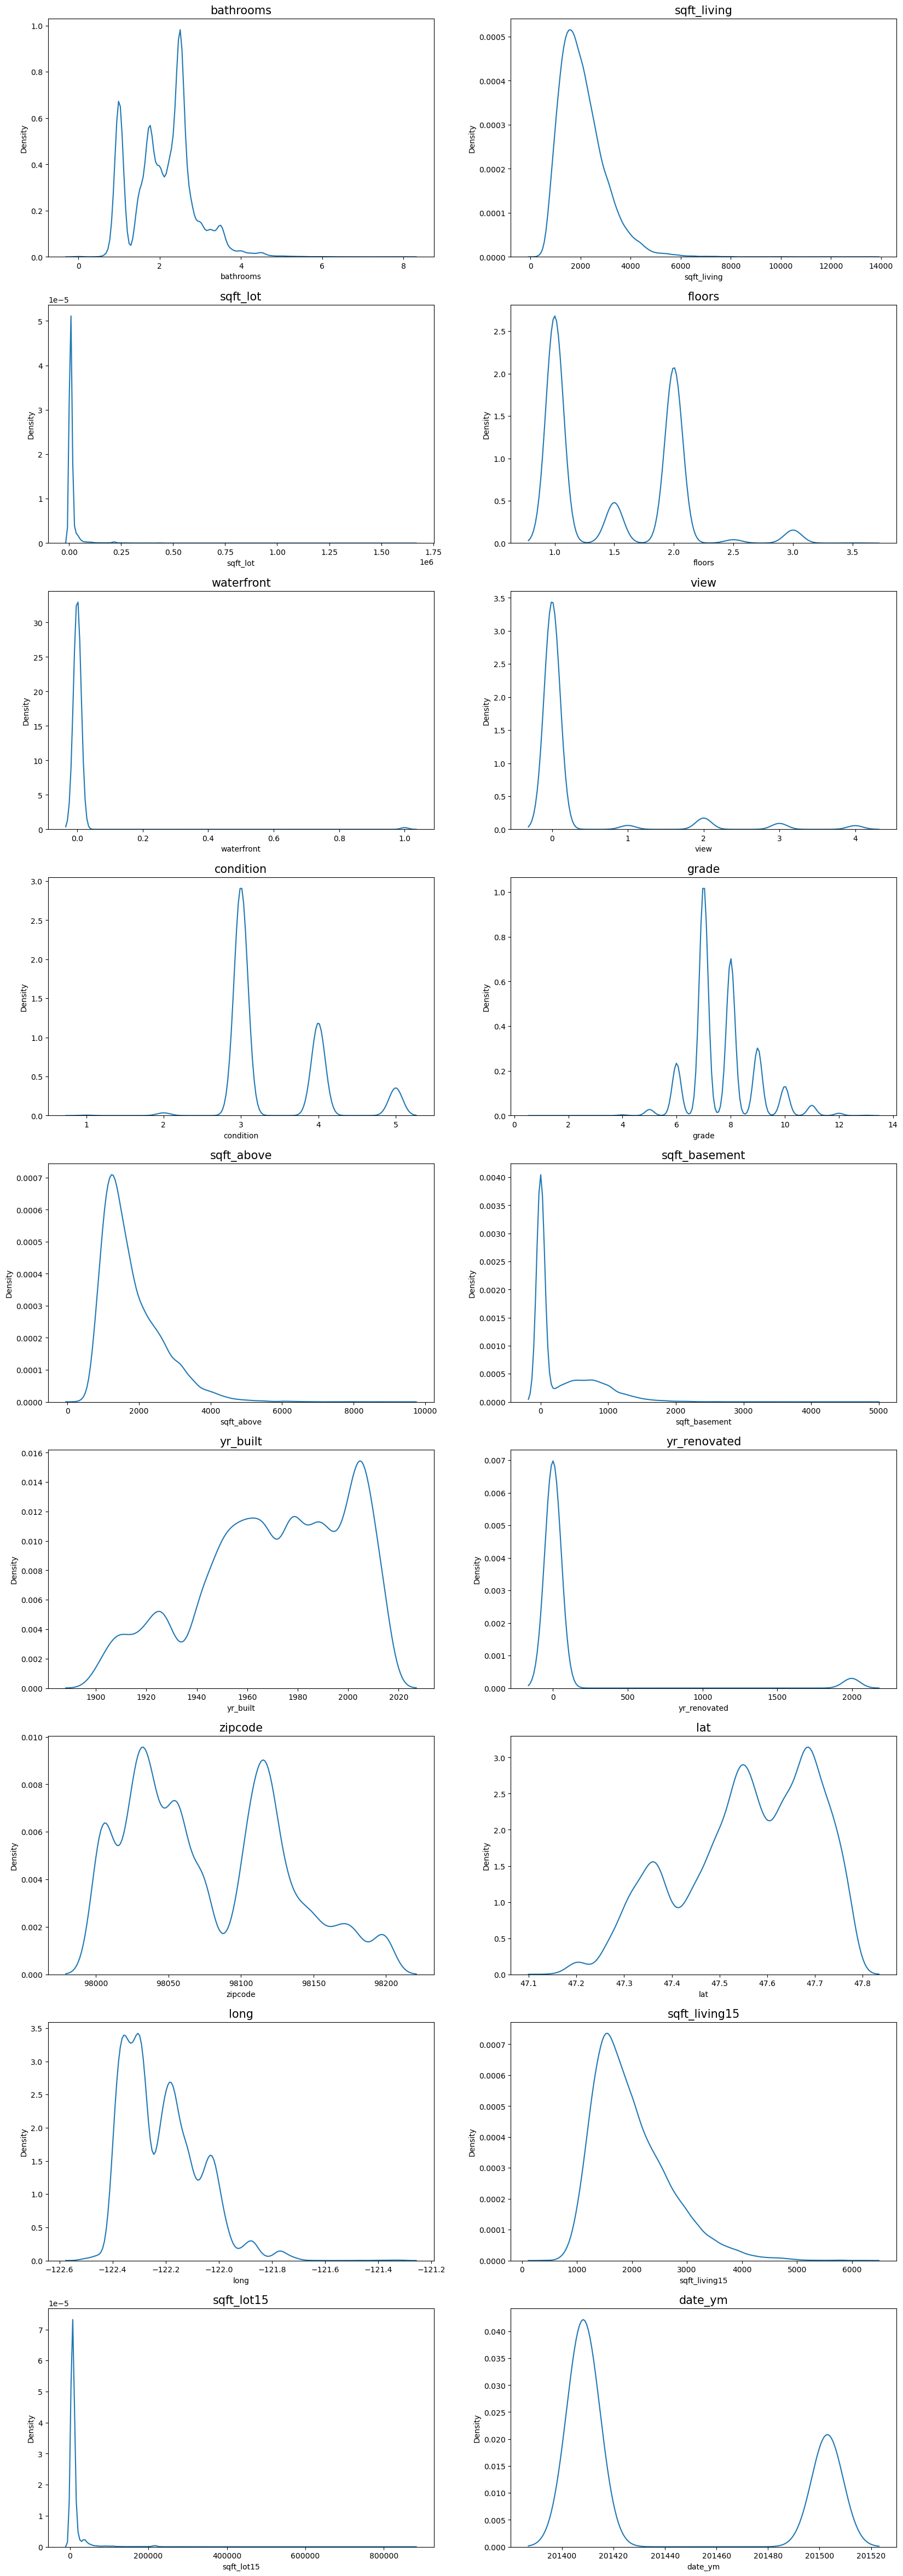

In [28]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [29]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', \
    'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values) 

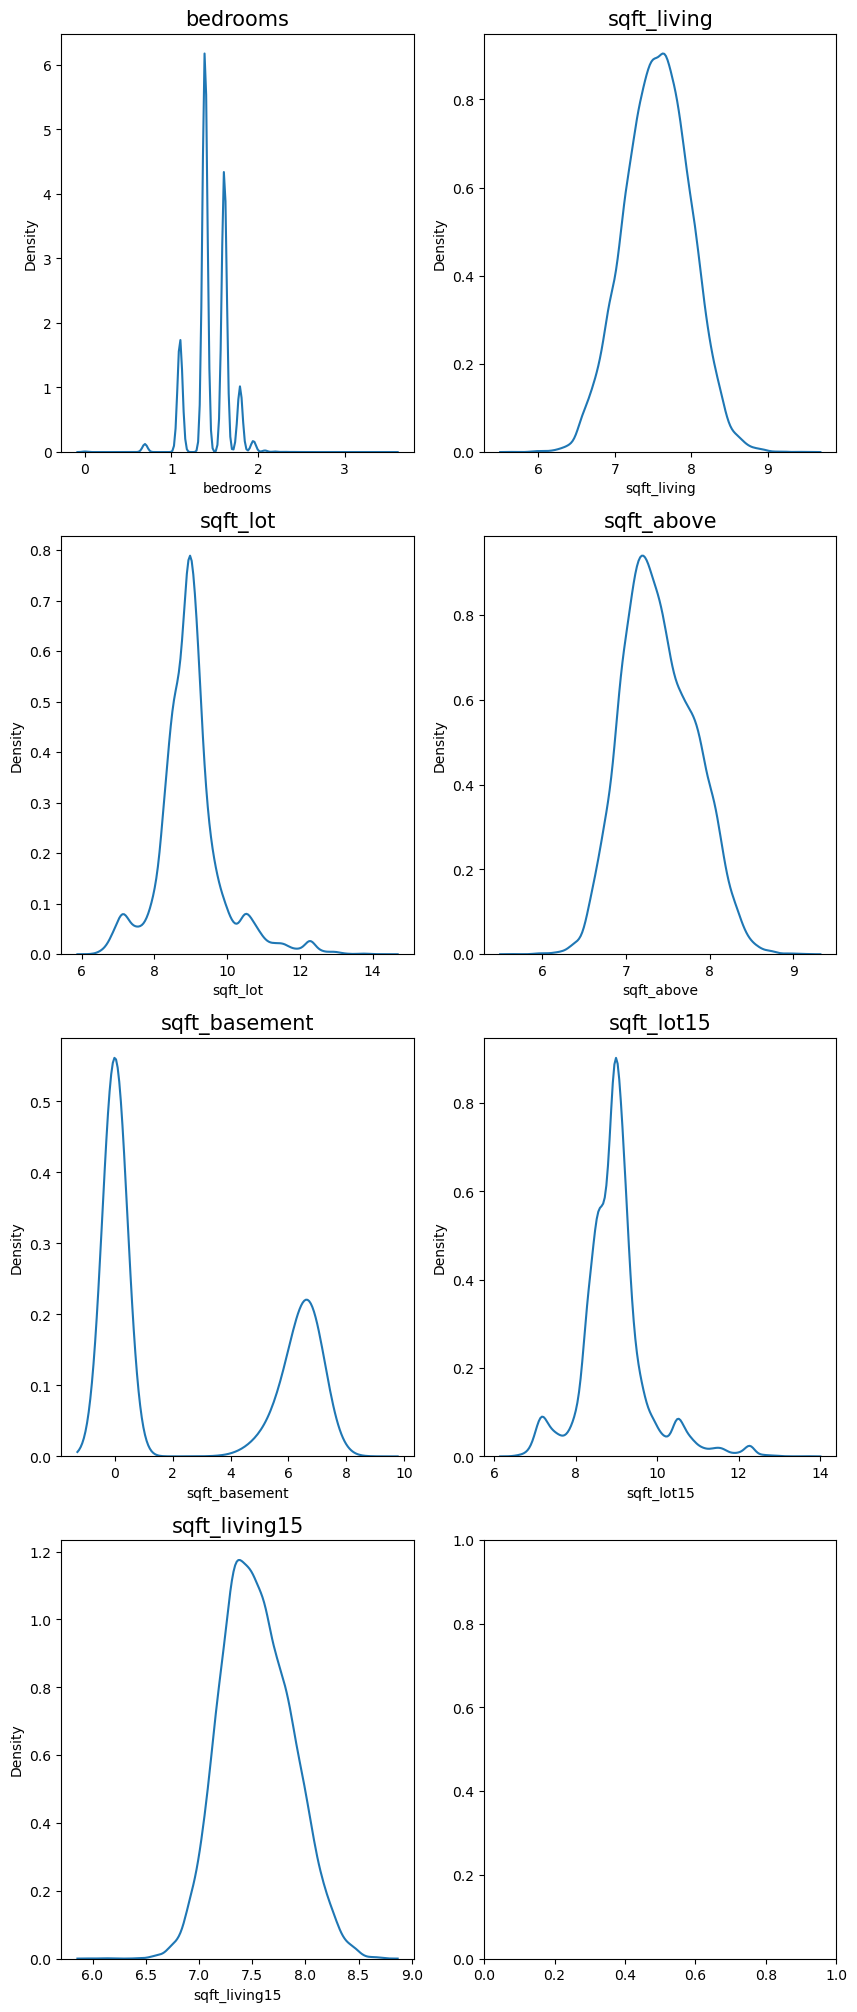

In [30]:
fig, ax = plt.subplots(4, 2, figsize=(10, 25))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



* 어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

### `label` 데이터 분포 확인

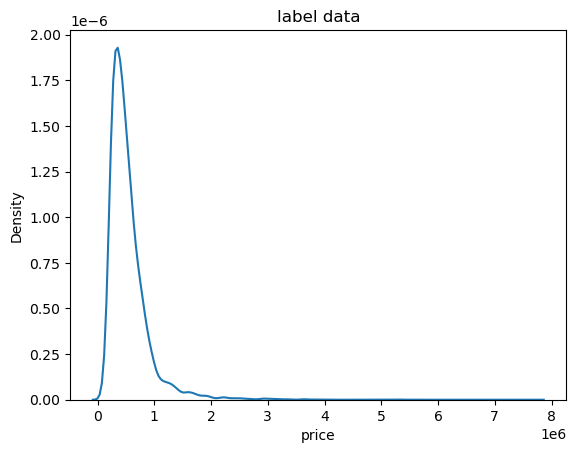

In [31]:
plt.figure()
sns.kdeplot(label)
plt.title('label data')
plt.show()

* log 스케일로 분포를 재조정한다.

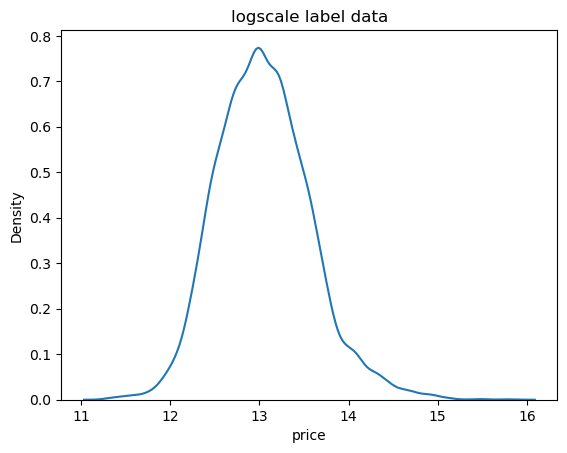

In [32]:
label_logscale = np.log1p(label)

sns.kdeplot(label_logscale)
plt.title('logscale label data')
plt.show()

In [33]:
train = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]

## 3. 모델링

### Grid Search


In [34]:
def my_GridSearch(model, train, label, param_grid, scoring='neg_mean_squared_error', verbose=2, n_jobs=5):
    '''
    sklearn의 GridSearchCV를 
    '''
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, label)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score

    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    return results

In [35]:
rand_state = 777
# 모델 정의
gboost = GradientBoostingRegressor(random_state=rand_state)
xgboost = xgb.XGBRegressor(random_state=rand_state)
lightgbm = lgb.LGBMRegressor(random_state=rand_state)
# rdforest = RandomForestRegressor(random_state=rand_state)

models = [gboost, xgboost, lightgbm] # rdforest
    
# 파라미터 Grid 설정
param_grid_gb = {
'n_estimators': [200, 300, 500],
'learning_rate': [0.05, 0.1, 0.15],
'max_depth': [5, 7, 10]
}

param_grid_xgb = {
'n_estimators': [200, 300, 500],
'learning_rate': [0.05, 0.1, 0.15],
'max_depth': [5, 7, 10]
}

param_grid_lgb = {
'n_estimators': [200, 300, 500],
'learning_rate': [0.05, 0.1, 0.15],
'max_depth': [5, 7, 10]
}

# param_grid_rf = {
# 'n_estimators': [200, 300, 500],
# 'max_depth': [None, 5, 10]
# }
params = [param_grid_gb,param_grid_xgb,param_grid_lgb] # param_grid_rf

# 파라미터 선택
best_params = {}
for i in range(len(models)):
    gs_data = my_GridSearch(models[i], train, label_logscale, params[i], verbose=2, n_jobs=5)
    best_gs = gs_data.iloc[0]
    best_params[models[i].__class__.__name__] = best_gs
    
best_params

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'GradientBoostingRegressor': learning_rate      0.050000
 max_depth          5.000000
 n_estimators     500.000000
 score             -0.026637
 RMSLE              0.163210
 Name: 2, dtype: float64,
 'XGBRegressor': learning_rate      0.050000
 max_depth          7.000000
 n_estimators     500.000000
 score             -0.025850
 RMSLE              0.160778
 Name: 5, dtype: float64,
 'LGBMRegressor': learning_rate      0.050000
 max_depth         10.000000
 n_estimators     500.000000
 score             -0.025928
 RMSLE              0.161021
 Name: 8, dtype: float64,
 'RandomForestRegressor': max_depth              NaN
 n_estimators    500.000000
 score            -0.031426
 RMSLE             0.177273
 Name: 2, dtype: float64}

```python
# 최적으로 찾은 파라미터 입력

gboost = GradientBoostingRegressor(**best_params[models[0]][:-2],
                                   random_state=rand_state)
xgboost = xgb.XGBRegressor(**best_params[models[1][:-2]],
                           random_state=rand_state)
lightgbm = lgb.LGBMRegressor(**best_params[models[2][:-2]],
                            random_state=rand_state)
rdforest = RandomForestRegressor(**best_params[models[3][:-2]],
                               random_state=rand_state)

```

In [53]:
# 최적으로 찾은 파라미터 입력
gb_learning_rate = 0.05
gb_max_depth = 5
gb_n_estimators = 500

xgb_learning_rate = 0.5
xgb_max_depth = 7
xgb_n_estimators = 500

lgb_learning_rate = 0.5
lgb_max_depth = 10
lgb_n_estimators = 500
 
# rf_max_depth = None
# rf_n_estimators = 500
 
gboost = GradientBoostingRegressor(learning_rate=gb_learning_rate, max_depth=gb_max_depth,
                                   n_estimators=gb_n_estimators, random_state=rand_state)
xgboost = xgb.XGBRegressor(learning_rate=xgb_learning_rate, max_depth=xgb_max_depth,
                            n_estimators=xgb_n_estimators,random_state=rand_state)
lightgbm = lgb.LGBMRegressor(learning_rate=lgb_learning_rate, max_depth=lgb_max_depth,
                            n_estimators=lgb_n_estimators,random_state=rand_state)
# rdforest = RandomForestRegressor(max_depth=rf_max_depth,n_estimators=rf_n_estimators,
#                                random_state=rand_state)


models = [gboost, xgboost, lightgbm] # rdforest



### RMSE
Kaggle의 점수를 RMSE로 평가하기에 
`XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor` 네 가지 모델의 성능을 평가하는 함수 


In [54]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test,y_pred))

def get_scores(models, train, label, random_state=42, test_size=0.3):
    df = {} 
    X_train, X_test, y_train, y_test = \
        train_test_split(train, label, test_size=test_size, random_state=random_state)

    for model in models:
        
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        df[model.__class__.__name__] = rmse(np.expm1(y_test), np.expm1(y_pred))
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

In [55]:
# 그리드 탐색으로 찾은 파라미터값으로 설정한 모델들의 RMSE
score = get_scores(models, train, label_logscale, random_state=rand_state, test_size=0.3)
score

,RMSE
RandomForestRegressor,157181.305563
XGBRegressor,148431.015542
GradientBoostingRegressor,138371.116266
LGBMRegressor,137646.112586


### Make Submission

훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [56]:
def AveragingBlending(models, train, label, sub):
    for m in models : 
        m.fit(train, label)
    
    predictions = np.column_stack([
        m.predict(sub) for m in models ])
    
    return np.mean(predictions, axis=1)

In [57]:
def save_submission(prediction, model_name, rmsle):
    
    submission = pd.DataFrame({'id' : sub_id, 'price': prediction})  
    
    submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    return submission

In [59]:
rmse_mean = round(np.mean(score['RMSE']))

prediction = AveragingBlending(models, train, label_logscale, sub)

save_submission(np.expm1(prediction), 'Average_Blending', str(rmse_mean))

c:\git_repos\Aiffel_Nodes\Project\Quest_02/House_Price_Prediction//submission_Average_Blending_RMSE_147994.csv saved!


,id,price
0,15035,5.207409e+05
1,15036,4.843892e+05
2,15037,1.360241e+06
3,15038,3.119930e+05
4,15039,3.038747e+05
...,...,...
6463,21498,2.161968e+05
6464,21499,4.123403e+05
6465,21500,5.014489e+05
6466,21501,3.082493e+05


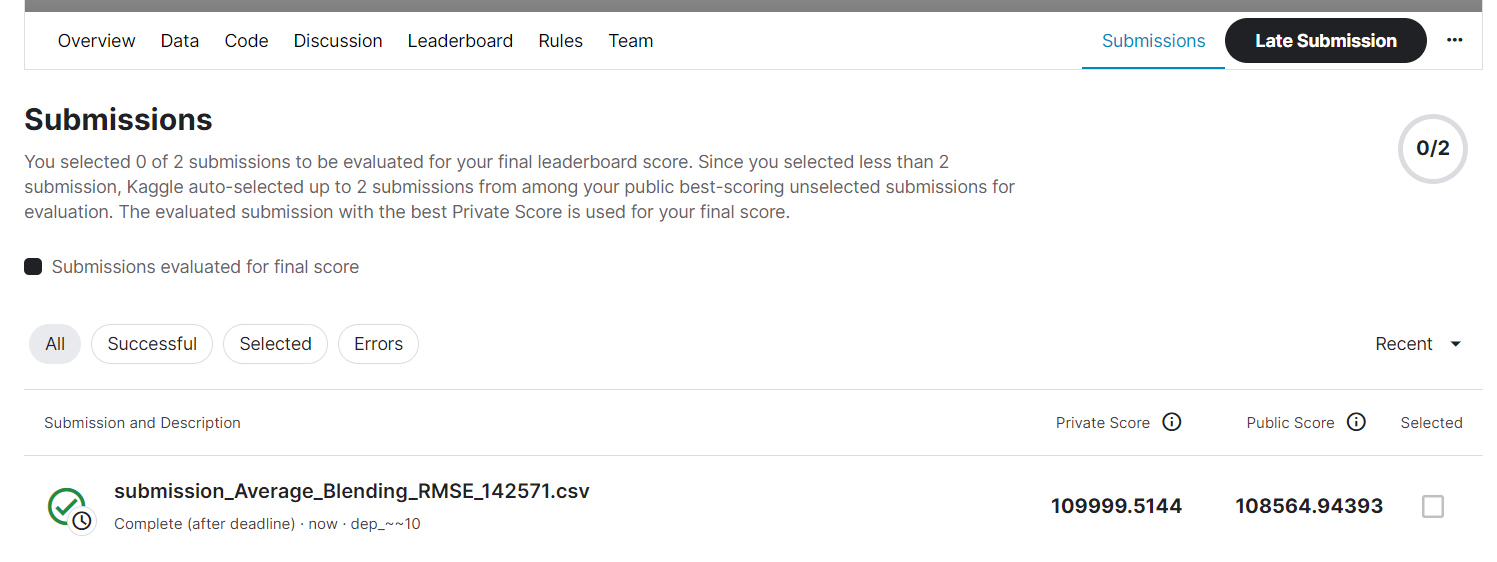